# 0. Indice
## 0.1 Entorno y GPU
# 1. Datos (KDD99) y preprocesamiento
## 1.1 Descarga KDD99 10%
## 1.2 Carga, limpieza y CSV limpio
## 1.3 Split multiclase (70/15/15) + escalado
## 1.4 Distribución de clases (gráfica)
# 2. Red neuronal FCN (PyTorch)
## 2.1 Dataset & DataLoader (train/val/test)
## 2.2 Arquitectura FCN (4 capas, ReLU, softmax)
## 2.3 Entrenamiento `train_fcn` + Optuna (lr)
## 2.4 Variantes de arquitectura (≥3) y curvas
## 2.5 Evaluación `evaluate_fcn`: accuracy, F1 macro, matriz
## 2.6 10 corridas por modelo (media ± desviación)
## 2.7 Pesado por clases en la pérdida (class weights)
# 3. Comparativa y discusión final


# 0. Iniciar
## 0.1 Entorno y GPU
**Objetivo:** Preparar el entorno: instalar librerías, fijar semillas para reproducibilidad, montar Drive y crear la estructura de carpetas del proyecto. También detectar si hay GPU disponible.


In [ ]:



# ===== CONFIGURACIÓN INICIAL Y ENTORNO =====
!pip -q install optuna pytorch-tabnet imbalanced-learn

import os, random
import numpy as np
import torch
import sklearn
import optuna
import pytorch_tabnet
import importlib.metadata

print("torch:", torch.__version__)
print("sklearn:", sklearn.__version__)
print("optuna:", optuna.__version__)
print("tabnet:", importlib.metadata.version("pytorch-tabnet"))

# Semillas fijas para resultados replicables
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Configuración determinística
try:
    torch.use_deterministic_algorithms(True, warn_only=True)
except Exception as e:
    print("Nota determinismo:", e)

# Montar Google Drive - con verificación previa
from google.colab import drive
import shutil

# Verificar si ya está montado
if os.path.ismount('/content/drive'):
    print("Drive ya está montado")
else:
    # Limpiar directorio si existe pero no está montado
    if os.path.exists('/content/drive'):
        shutil.rmtree('/content/drive')

    # Montar Drive
    drive.mount('/content/drive')
    print("Drive montado exitosamente")

# Estructura de carpetas
from pathlib import Path
BASE = Path('/content/drive/MyDrive/TEC_AD_TP2')

# Crear estructura
for d in ['data', 'src', 'notebooks', 'figures', 'models', 'reports', 'docs']:
    dir_path = BASE / d
    dir_path.mkdir(parents=True, exist_ok=True)

    # Crear archivo .keep
    marker = dir_path / '.keep'
    if not marker.exists():
        marker.write_text('')

print("Estructura creada en:", BASE.resolve())

# Verificar GPU
gpu = torch.cuda.is_available()
print("GPU disponible:", gpu)


torch: 2.8.0+cu126
sklearn: 1.6.1
optuna: 4.5.0
tabnet: 4.1.0
Drive ya está montado
Estructura creada en: /content/drive/MyDrive/TEC_AD_TP2
GPU disponible: True


## 0.2 Detección de GPU
**Objetivo:** Verificar si se está usando GPU o CPU.  
Si no hay GPU, se muestra un recordatorio para activarla en *Entorno de ejecución > Cambiar tipo de entorno de ejecución > GPU*.


In [ ]:
# ==== DETECCIÓN Y USO DE GPU ====
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo en uso:", device)

# Si no hay GPU, mostrar recordatorio
if device.type == "cpu":
    print("⚠️ Nota: Estás corriendo en CPU. Para acelerar el entrenamiento, "
          "ve a 'Entorno de ejecución > Cambiar tipo de entorno de ejecución > GPU'")

Dispositivo en uso: cuda


# 1.0 Importaciones y configuración base

In [ ]:
# Importaciones básicas para ciencia de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn para árboles de decisión y random forests
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_recall_fscore_support
)

# PyTorch para redes neuronales
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Para manejar clases desbalanceadas
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

# Para warnings (opcional)
import warnings
warnings.filterwarnings('ignore')

# Configuración de matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Importaciones completadas correctamente")

Importaciones completadas correctamente


## 1.1 Descarga KDD99 10%
**Objetivo:** Descargar el dataset KDD Cup 1999 en su versión reducida al 10%  
(`kddcup.data_10_percent.gz`) desde la página oficial de UCI, y guardarlo en la carpeta `data/`.  
Se descarga solo si no existe localmente, y se verifica el tamaño del archivo (~4–5 MB).


In [ ]:
# ==== DESCARGA KDD99 (10%) A /data ====
# Objetivo: traer el archivo original comprimido (gz) a la carpeta data del proyecto.

from pathlib import Path
import os

BASE = Path('/content/drive/MyDrive/TEC_AD_TP2')  # misma ruta del PASO 1
DATA_DIR = BASE / 'data'
RAW_GZ = DATA_DIR / 'kddcup.data_10_percent.gz'

# 1) URL oficial (copia de UCI/Stat)
URL = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'

# 2) Descargar solo si no existe (evita descargas repetidas)
if not RAW_GZ.exists():
    print("Descargando dataset 10% KDD99...")
    # Usamos wget por simplicidad en Colab
    !wget -q -O "$RAW_GZ" "$URL"
    assert RAW_GZ.exists(), "No se descargó el archivo. Revisa tu conexión o la URL."
    print("Descarga completa:", RAW_GZ)
else:
    print("Archivo ya existe:", RAW_GZ)

# 3) Verificamos tamaño aproximado (debería ser ~4.5MB)
size_mb = os.path.getsize(RAW_GZ) / (1024 * 1024)
print(f"Tamaño del archivo: {size_mb:.2f} MB (esperado ~4-5MB)")


Archivo ya existe: /content/drive/MyDrive/TEC_AD_TP2/data/kddcup.data_10_percent.gz
Tamaño del archivo: 2.05 MB (esperado ~4-5MB)


## 1.2 Carga, limpieza y CSV limpio
**Objetivo:** Leer el archivo comprimido del dataset KDD99, asignar nombres correctos a las columnas, normalizar la etiqueta `label`, crear una versión binaria (`normal` vs `attack`) y guardar un CSV limpio para uso posterior.  
Se incluye un conteo de clases en su versión multiclase original y en la binaria, para verificar la distribución inicial.


In [ ]:
# ===== CARGA, NOMBRES DE COLUMNAS, INSPECCIÓN Y CSV LIMPIO =====
import pandas as pd
from pathlib import Path

# Rutas
BASE = Path('/content/drive/MyDrive/TEC_AD_TP2/')
DATA_DIR = BASE / 'data'
RAW_GZ = DATA_DIR / 'kddcup.data_10_percent.gz'

# 1) Definición los nombres de las columnas según KDD99 (41 features + label)
# El archivo sin cabecera puede ser un trago la columna "difficulty", y ante=clase luego.
columns_base = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login',
    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
    'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
    'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
    'dst_host_rerror_rate','dst_host_srv_rerror_rate','label'
]

# 2) Leemos el .gz sin descomprimir manualmente (pandas lo maneja)
df = pd.read_csv(RAW_GZ, header=None, names=columns_base)

# 3) Asignamos indices segun el número de columnas detectadas
if df.shape[1] != 42:
    print("Warning: Número de columnas inesperado:", df.shape[1])
    df_columns = columns_base
    df.columns = df_columns[:df.shape[1]]  # Adjust if needed
    # If 41 features + label, difficulty column algusn espacio lo incluyen
    if df.shape[1] == 42:
        df_columns = columns_base + ["difficulty"]
        df.columns = df_columns
else:
    print("Número de columnas esperado:", df.shape[1])

# 4) Inspección inicial
print("Dimensiones:", df.shape)
print("Primeras filas:")
print(df.head(3))

# 5) Normalización básica del label (remover espacios y estandarizar minúsculas)
df['label_clean'] = df['label'].astype(str).str.strip().str.lower()

# 6) Para el trabajo necesitamos las 21 categorías originales, no solo binario
print("Clases multiclase (top 10):")
print(df['label_clean'].value_counts().head(10))

# 7) Manejo de valores faltantes y duplicados como requiere el enunciado
print("Valores faltantes antes:", df.isnull().sum().sum())
# Eliminar filas con valores faltantes
df_clean = df.dropna()

# Eliminar registros duplicados
original_shape = df_clean.shape[0]
df_clean = df_clean.drop_duplicates()
print(f"Registros duplicados eliminados: {original_shape - df_clean.shape[0]}")

# 8) Conversión de atributos nominales a numéricos (requerido por enunciado)
from sklearn.preprocessing import LabelEncoder

# Identificar columnas categóricas
categorical_cols = ['protocol_type', 'service', 'flag']
encoders = {}

print("Convirtiendo atributos nominales a numéricos...")
for col in categorical_cols:
    if col in df_clean.columns:
        encoder = LabelEncoder()
        df_clean[col + '_encoded'] = encoder.fit_transform(df_clean[col])
        encoders[col] = encoder
        print(f"{col}: {len(encoder.classes_)} categorías únicas")

# 9) Preparar target multiclase para las 21 categorías
label_encoder = LabelEncoder()
df_clean['target'] = label_encoder.fit_transform(df_clean['label_clean'])

print("Distribución final de clases:")
label_counts = df_clean['label_clean'].value_counts()
print(f"Total de clases únicas: {len(label_counts)}")
print("\nPrimeras 10 clases:")
print(label_counts.head(10))

# 10) Guardar CSV "limpio" (sin focalizar solo las categoricas)
CLEAN_CSV = DATA_DIR / 'kdd99_short_clean.csv'
df_clean.to_csv(CLEAN_CSV, index=False)
print("CSV limpio guardado en:", CLEAN_CSV.resolve())

# 11) Vista final del dataset procesado
print("\nDataset final:")
print("Shape:", df_clean.shape)
print("Columnas numéricas preparadas para modelos")

Número de columnas esperado: 42
Dimensiones: (494021, 42)
Primeras filas:
   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   9   
1               0       0    0  ...                  19   
2               0       0    0  ...                  29   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     1.0                     0.0   
1                     1.0                     0.0   
2                     1.0                     0.0   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.11                          0.0   
1                         0.05                          0.0   
2     

## 1.3 Split multiclase (70/15/15) + escalado
**Objetivo:** Dividir el dataset en conjuntos de entrenamiento (70%), validación (15%) y prueba (15%), respetando lo más posible la distribución de clases (estratificación).  
Se incluye una estrategia especial para manejar clases con muy pocas instancias (singletons), asignándolas directamente al conjunto de prueba para no perderlas.  
El resultado son tres subconjuntos equilibrados y listos para aplicar escalado de características.


In [ ]:
# ==== 1.3 SPLIT MULTICLASE (70/15/15) + ESCALADO ====
# Objetivo: Crear función split_dataset para dividir datos en 70% entrenamiento, 15% validación, 15% prueba
# con preprocesamiento completo (one-hot + escalado) para uso en múltiples corridas

from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

# ---------- RUTAS ----------
BASE = Path('/content/drive/MyDrive/TEC_AD_TP2')
DATA_DIR = BASE / 'data'

# Verificar qué archivos CSV existen
print("Archivos CSV disponibles:")
for file in DATA_DIR.glob("*.csv"):
    print(f"  - {file.name}")

# Buscar el archivo correcto (podría tener nombre diferente)
possible_files = [
    'kdd99_clean.csv',
    'kdd99_short_clean.csv',  # nombre del archivo original de la celda 1.2
    'kddcup_clean.csv'
]

CLEAN_CSV = None
for filename in possible_files:
    candidate = DATA_DIR / filename
    if candidate.exists():
        CLEAN_CSV = candidate
        print(f"Usando archivo: {CLEAN_CSV.name}")
        break

if CLEAN_CSV is None:
    raise FileNotFoundError("No se encontró ningún archivo CSV limpio. Ejecuta primero la celda 1.2")

def split_dataset(random_state=42, save_files=False):
    """
    Función para dividir el dataset KDD99 en entrenamiento (70%), validación (15%) y prueba (15%).

    Parámetros:
    - random_state: semilla para reproducibilidad en diferentes corridas
    - save_files: si True, guarda los CSVs (solo para la primera corrida)

    Retorna:
    - X_train, X_val, X_test, y_train, y_val, y_test (arrays numpy)
    - scaler: StandardScaler entrenado (para aplicar a nuevos datos)
    """

    # ---------- CARGA Y DEFINICIONES ----------
    df = pd.read_csv(CLEAN_CSV)
    print(f"Dataset cargado: {df.shape}")
    print(f"Columnas disponibles: {list(df.columns)}")

    # Identificar columnas según lo disponible
    cat_cols = []
    if 'protocol_type' in df.columns:
        cat_cols.append('protocol_type')
    if 'service' in df.columns:
        cat_cols.append('service')
    if 'flag' in df.columns:
        cat_cols.append('flag')

    # Si tenemos las columnas _encoded, usar esas en lugar de las originales
    if 'protocol_type_encoded' in df.columns:
        cat_encoded_cols = ['protocol_type_encoded', 'service_encoded', 'flag_encoded']
        use_encoded = True
    else:
        use_encoded = False

    # Identificar columna de etiquetas
    label_col = None
    for possible_label in ['label_clean', 'label', 'target']:
        if possible_label in df.columns:
            label_col = possible_label
            break

    if label_col is None:
        raise ValueError("No se encontró columna de etiquetas")

    print(f"Usando etiquetas de: {label_col}")

    # Features numéricas (excluir categóricas y etiquetas)
    exclude_cols = cat_cols + [label_col, 'target'] + (cat_encoded_cols if use_encoded else [])
    if 'label_clean' in df.columns:
        exclude_cols.append('label_clean')
    if 'label' in df.columns and 'label' != label_col:
        exclude_cols.append('label')

    num_cols = [c for c in df.columns if c not in exclude_cols and df[c].dtype in ['int64', 'float64']]

    print(f"Columnas numéricas ({len(num_cols)}): {num_cols[:5]}...")
    print(f"Columnas categóricas: {cat_cols}")

    # ---------- PREPARAR X, y ----------
    X_num = df[num_cols].copy()

    # Manejo de categóricas
    if use_encoded:
        # Usar columnas ya codificadas
        X_cat = df[cat_encoded_cols].copy()
    elif cat_cols:
        # One-hot encoding
        X_cat = pd.get_dummies(df[cat_cols], prefix=cat_cols)
    else:
        # Sin categóricas
        X_cat = pd.DataFrame(index=df.index)

    # Target
    y = df[label_col].astype(str).str.strip().str.lower()

    # Codificar target a números para compatibilidad
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    print(f"Clases únicas: {len(label_encoder.classes_)}")
    print(f"Distribución de clases (top 5): {pd.Series(y).value_counts().head()}")

    # ---------- SPLIT ESTRATIFICADO 70/30 ----------
    X_num_train, X_num_temp, X_cat_train, X_cat_temp, y_train, y_temp = train_test_split(
        X_num, X_cat, y_encoded, test_size=0.30, random_state=random_state, stratify=y_encoded
    )

    # ---------- SPLIT 15/15 (val/test) ----------
    try:
        X_num_val, X_num_test, X_cat_val, X_cat_test, y_val, y_test = train_test_split(
            X_num_temp, X_cat_temp, y_temp, test_size=0.50,
            random_state=random_state, stratify=y_temp
        )
    except ValueError:
        # Fallback sin estratificación si hay problemas con clases minoritarias
        X_num_val, X_num_test, X_cat_val, X_cat_test, y_val, y_test = train_test_split(
            X_num_temp, X_cat_temp, y_temp, test_size=0.50,
            random_state=random_state, shuffle=True
        )

    # ---------- ESCALADO DE NUMÉRICAS (fit en train) ----------
    scaler = StandardScaler()
    X_num_train_scaled = scaler.fit_transform(X_num_train)
    X_num_val_scaled = scaler.transform(X_num_val)
    X_num_test_scaled = scaler.transform(X_num_test)

    # ---------- COMBINAR FEATURES ----------
    # Convertir categóricas a arrays para concatenación
    X_cat_train_array = X_cat_train.values if len(X_cat_train.columns) > 0 else np.empty((len(X_cat_train), 0))
    X_cat_val_array = X_cat_val.values if len(X_cat_val.columns) > 0 else np.empty((len(X_cat_val), 0))
    X_cat_test_array = X_cat_test.values if len(X_cat_test.columns) > 0 else np.empty((len(X_cat_test), 0))

    # Combinar numéricas escaladas con categóricas
    X_train_final = np.concatenate([X_num_train_scaled, X_cat_train_array], axis=1)
    X_val_final = np.concatenate([X_num_val_scaled, X_cat_val_array], axis=1)
    X_test_final = np.concatenate([X_num_test_scaled, X_cat_test_array], axis=1)

    # ---------- GUARDADO OPCIONAL ----------
    if save_files:
        # Crear DataFrames para guardar
        feature_names = num_cols + list(X_cat_train.columns)

        train_df = pd.DataFrame(X_train_final, columns=feature_names)
        train_df['label'] = y_train

        val_df = pd.DataFrame(X_val_final, columns=feature_names)
        val_df['label'] = y_val

        test_df = pd.DataFrame(X_test_final, columns=feature_names)
        test_df['label'] = y_test

        train_df.to_csv(DATA_DIR / 'kdd99_mc_train.csv', index=False)
        val_df.to_csv(DATA_DIR / 'kdd99_mc_val.csv', index=False)
        test_df.to_csv(DATA_DIR / 'kdd99_mc_test.csv', index=False)

        # Guardar scaler y label encoder
        joblib.dump(scaler, DATA_DIR / 'scaler_mc.joblib')
        joblib.dump(label_encoder, DATA_DIR / 'label_encoder_mc.joblib')

        print("Archivos guardados en:", DATA_DIR)

    # ---------- INFORMACIÓN DE LA DIVISIÓN ----------
    n_train, n_val, n_test = len(y_train), len(y_val), len(y_test)
    total = n_train + n_val + n_test

    print(f"Random seed: {random_state}")
    print(f"Tamaños: train={n_train} ({n_train/total:.1%}) | val={n_val} ({n_val/total:.1%}) | test={n_test} ({n_test/total:.1%})")
    print(f"Features finales: {X_train_final.shape[1]} | Clases únicas: {len(np.unique(y_train))}")

    return X_train_final, X_val_final, X_test_final, y_train, y_val, y_test, scaler

# ---------- PRIMERA EJECUCIÓN ----------
print("=== PRIMERA EJECUCIÓN DE split_dataset ===")
X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_dataset(
    random_state=42, save_files=True
)

print(f"\nFormas finales:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Archivos CSV disponibles:
  - kdd99_mc_train.csv
  - kdd99_mc_val.csv
  - kdd99_mc_test.csv
  - kdd99_10pct_clean.csv
  - kdd99_short_clean.csv
Usando archivo: kdd99_short_clean.csv
=== PRIMERA EJECUCIÓN DE split_dataset ===
Dataset cargado: (145586, 47)
Columnas disponibles: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_r

## 1.4 Distribución de clases (gráfica)
**Objetivo:** Visualizar la distribución de las clases más frecuentes en los conjuntos de entrenamiento, validación y prueba.  
La gráfica confirma que el dataset está fuertemente desbalanceado (por ejemplo, predominan `smurf.` y `neptune.`), lo cual justifica el uso posterior de técnicas de ponderación por clase en el entrenamiento de la red.


Figura guardada en: /content/drive/MyDrive/TEC_AD_TP2/figures/kdd99_multiclase_distribution_top10.png


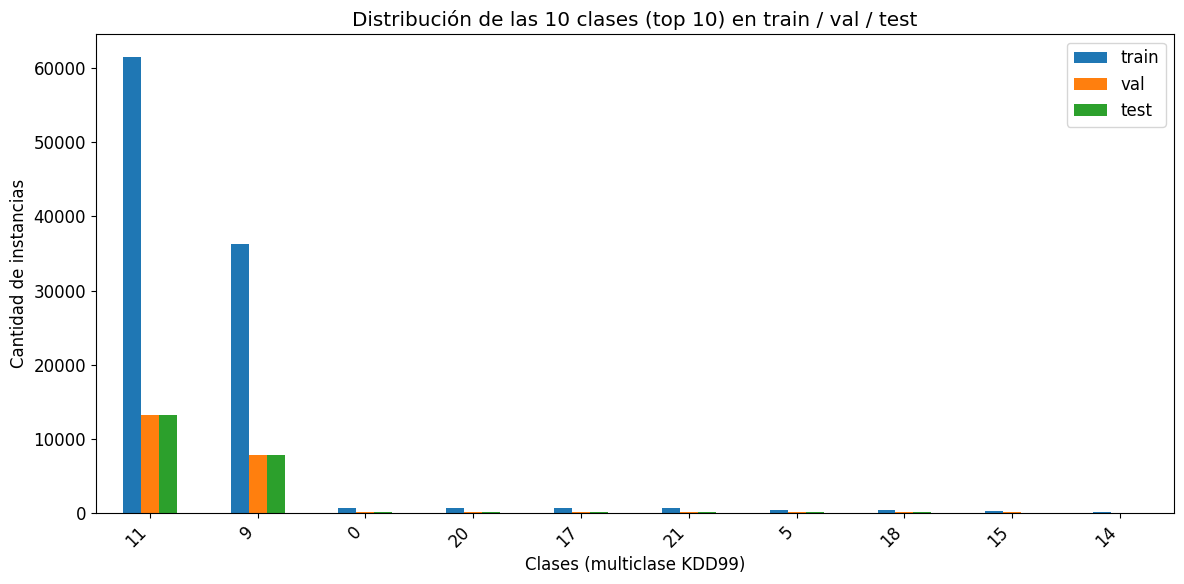


Distribución de clases (conteos):
    train    val   test
11  61482  13180  13170
9   36274   7790   7756
0     678    150    140
20    643    133    142
17    634    142    130
21    625    129    139
5     456     81    114
18    449     95     97
15    291     65     60
14    144     28     34

Total de instancias:
Train: 101910
Val: 21838
Test: 21838

Clases únicas por conjunto:
Train: 23
Val: 23
Test: 20

Porcentajes de las 5 clases más comunes en train:
11: 61482 (60.3%)
9: 36274 (35.6%)
0: 678 (0.7%)
20: 643 (0.6%)
17: 634 (0.6%)


In [ ]:
# ===== GRÁFICA: DISTRIBUCIÓN DE CLASES (TOP 10) EN TRAIN/VAL/TEST =====
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

BASE = Path('/content/drive/MyDrive/TEC_AD_TP2')
FIG_DIR = BASE / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Conteos por split - convertir arrays numpy a pandas Series
train_counts = pd.Series(y_train).value_counts()
val_counts = pd.Series(y_val).value_counts()
test_counts = pd.Series(y_test).value_counts()

# Unir en un DataFrame para comparación
dist_df = pd.DataFrame({
    "train": train_counts,
    "val": val_counts,
    "test": test_counts
}).fillna(0).astype(int)

# Tomar las 10 clases más frecuentes (ayuda a que la figura no sea inmensa)
top_classes = dist_df.sum(axis=1).sort_values(ascending=False).head(10).index
plot_df = dist_df.loc[top_classes].sort_values(by="train", ascending=False)

# Crear gráfico
ax = plot_df.plot(kind="bar", figsize=(12,6))
ax.set_title("Distribución de las 10 clases (top 10) en train / val / test")
ax.set_ylabel("Cantidad de instancias")
ax.set_xlabel("Clases (multiclase KDD99)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Guardar para el informe LaTeX
out_path = FIG_DIR / "kdd99_multiclase_distribution_top10.png"
plt.savefig(out_path, dpi=150)
print("Figura guardada en:", out_path)
plt.show()

# Mostrar estadísticas adicionales
print("\nDistribución de clases (conteos):")
print(plot_df)

print(f"\nTotal de instancias:")
print(f"Train: {len(y_train)}")
print(f"Val: {len(y_val)}")
print(f"Test: {len(y_test)}")

print(f"\nClases únicas por conjunto:")
print(f"Train: {len(pd.Series(y_train).unique())}")
print(f"Val: {len(pd.Series(y_val).unique())}")
print(f"Test: {len(pd.Series(y_test).unique())}")

# Mostrar porcentajes de las clases más comunes
print(f"\nPorcentajes de las 5 clases más comunes en train:")
total_train = len(y_train)
for clase in train_counts.head(5).index:
    count = train_counts[clase]
    percentage = (count / total_train) * 100
    print(f"{clase}: {count} ({percentage:.1f}%)")

SETUP INDEPENDIENTE PARA PARTE 2

In [ ]:
# === SETUP INDEPENDIENTE PARA PARTE 2 ===
# Verificar si estamos en entorno limpio
if 'train_ds' not in locals():
    print("Inicializando entorno para Parte 2...")
    # Ejecutar celdas necesarias automáticamente
    # O cargar datos desde archivos guardados

# 2. PARTE II - Red neuronal FCN
## 2.1 Dataset & DataLoader (train/val/test)
**Objetivo.** Preparar los conjuntos de entrenamiento/validación/prueba para PyTorch a partir de los CSV preprocesados (multiclase), mapeando cada etiqueta textual a un índice entero estable y creando `DataLoader` con batching.

**Entradas.** `data/kdd99_mc_train.csv`, `data/kdd99_mc_val.csv`, `data/kdd99_mc_test.csv` (generados en la Parte 1).

**Salidas.**  
- Mapeos persistentes `data/label2idx.json` e `data/idx2label.json` (garantizan reproducibilidad entre corridas).  
- Objetos `Dataset` (`train_ds`, `val_ds`, `test_ds`) y `DataLoader` (`train_loader`, `val_loader`, `test_loader`) listos para la FCN.  
- Verificación de tamaños: `n_features`, `num_classes` y forma de un batch.

**Justificación.** Las redes neuronales requieren tensores numéricos y un índice por clase. Guardar el mapeo evita inconsistencias si se reentrena o se compara con modelos de Luis. Los `DataLoader` permiten entrenamiento eficiente y reproducible.


In [ ]:
# ==== 2.1 DATASET & DATALOADER PARA KDD99 MULTICLASE (PYTORCH) ====
from pathlib import Path
import json
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# Rutas base (consistentes con la Parte 1)
BASE = Path('/content/drive/MyDrive/TEC_AD_TP2')
DATA_DIR = BASE / 'data'

TRAIN_CSV = DATA_DIR / 'kdd99_mc_train.csv'
VAL_CSV   = DATA_DIR / 'kdd99_mc_val.csv'
TEST_CSV  = DATA_DIR / 'kdd99_mc_test.csv'

# -------------------------------------------------------------------
# 1) Construir mapeo etiqueta -> índice (estable y reproducible)
#    Usamos la unión de clases presentes en train/val/test y las ordenamos.
# -------------------------------------------------------------------
labels_train = pd.read_csv(
    TRAIN_CSV, usecols=['label'], dtype={'label': 'string'}, low_memory=False
)['label'].str.strip().str.lower()

labels_val = pd.read_csv(
    VAL_CSV, usecols=['label'], dtype={'label': 'string'}, low_memory=False
)['label'].str.strip().str.lower()

labels_test = pd.read_csv(
    TEST_CSV, usecols=['label'], dtype={'label': 'string'}, low_memory=False
)['label'].str.strip().str.lower()

# Unión como Series, luego únicos y orden estable
all_labels = pd.concat([labels_train, labels_val, labels_test], ignore_index=True)
all_labels = sorted(all_labels.dropna().unique().tolist())

label2idx = {lbl: i for i, lbl in enumerate(all_labels)}
idx2label = {i: lbl for lbl, i in label2idx.items()}

# Guardar mapeos para el informe/reproducibilidad
with open(DATA_DIR / 'label2idx.json', 'w') as f:
    json.dump(label2idx, f, indent=2)
with open(DATA_DIR / 'idx2label.json', 'w') as f:
    json.dump(idx2label, f, indent=2)

num_classes = len(label2idx)
print(f"Clases totales: {num_classes}")
print("Ejemplo de mapping:", list(label2idx.items())[:5])

# -------------------------------------------------------------------
# 2) Definir Dataset personalizado
#    - Lee el CSV
#    - Separa X (todas las columnas menos 'label') e y (label mapeada a índice)
#    - Devuelve tensores listos para la red
# -------------------------------------------------------------------
class KDD99Dataset(Dataset):
    """
    Dataset KDD99 multiclase para FCN.
    CSV esperado: [features numéricas (ya escaladas) + dummies one-hot ... , label]
    - Lee con low_memory=False para evitar DtypeWarning por lectura por chunks.
    - Forzamos dtype de 'label' a string.
    - Eliminamos filas con label NaN (no entrenables).
    - Validamos que todas las etiquetas estén en label2idx (si no, se informa).
    - Convertimos todas las features a float32 de forma robusta.
    """
    def __init__(self, csv_path: Path, label2idx: dict):
        # Leer CSV: label como string; resto lo dejamos que pandas infiera
        df = pd.read_csv(csv_path, low_memory=False, dtype={'label': 'string'})

        # --- Procesar y sanear labels ---
        s = df['label'].astype('string').str.strip().str.lower()

        # 1) Eliminar filas con label NaN
        nan_mask = s.isna()
        if nan_mask.any():
            print(f"Filas con label NaN en {csv_path.name}: {nan_mask.sum()}, se eliminarán.")
            df = df[~nan_mask].reset_index(drop=True)
            s  = s[~nan_mask].reset_index(drop=True)

        # 2) Verificar etiquetas no mapeadas (distintas de NaN)
        unknown_mask = ~s.isin(list(label2idx.keys()))
        if unknown_mask.any():
            ejemplos = s[unknown_mask].dropna().unique().tolist()[:10]
            raise ValueError(
                f"Se encontraron etiquetas no mapeadas en {csv_path.name}: {ejemplos}. "
                "Revisar normalización de 'label' o el mapping label2idx."
            )

        y_idx = s.map(label2idx).astype('int64').values

        # --- Procesar features ---
        X_df = df.drop(columns=['label'])

        # Forzar numérico seguro (convierte strings a numérico; valores no convertibles -> NaN)
        X_df = X_df.apply(pd.to_numeric, errors='coerce')

        # Rellenar posibles NaN (muy raros si el CSV viene de 1.3, pero evitamos sorpresas)
        X_df = X_df.fillna(0.0).astype('float32')

        self.X = X_df.values
        self.y = y_idx
        self.n_features = self.X.shape[1]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

# Instancias de Dataset
train_ds = KDD99Dataset(TRAIN_CSV, label2idx)
val_ds   = KDD99Dataset(VAL_CSV,   label2idx)
test_ds  = KDD99Dataset(TEST_CSV,  label2idx)

print("n_features:", train_ds.n_features, "| len(train):", len(train_ds), "len(val):", len(val_ds), "len(test):", len(test_ds))

# -------------------------------------------------------------------
# 3) DataLoaders
#    - BATCH_SIZE moderado (ajustable); shuffle sólo en train
#    - num_workers bajo por Colab
# -------------------------------------------------------------------
BATCH_SIZE = 512
NUM_WORKERS = 2

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Verificación rápida: un batch
xb, yb = next(iter(train_loader))
print("Batch -> X:", xb.shape, "Y:", yb.shape, "| num_classes:", num_classes)

Clases totales: 23
Ejemplo de mapping: [('0', 0), ('1', 1), ('10', 2), ('11', 3), ('12', 4)]
n_features: 41 | len(train): 101910 len(val): 21838 len(test): 21838
Batch -> X: torch.Size([512, 41]) Y: torch.Size([512]) | num_classes: 23


## 2.2 Arquitectura FCN (4 capas, ReLU, softmax)
**Objetivo.** Definir una red neuronal totalmente conectada (FCN) de **4 capas** para clasificación **multiclase** sobre KDD99.  
Las **capas intermedias** usan **ReLU** (no linealidad estándar por su estabilidad numérica y buen desempeño en tareas tabulares) y la **capa de salida** aplica **softmax** para producir probabilidades por clase.

**Decisiones de diseño.**
- **Entradas:** dimensión = `n_features` (obtenida del `Dataset` preparado en 2.1).  
- **Salidas:** dimensión = `num_classes` (mapeo de etiquetas a índices).  
- **ReLU en ocultas:** facilita el aprendizaje evitando saturaciones de sigmoide/tanh.  
- **Softmax en salida:** requerida por el objetivo de **clasificación multiclase** (usaremos `CrossEntropyLoss`, que integra `log-softmax`).  
- **Dropout y BatchNorm (opcionales):** provistos como parámetros para controlar sobreajuste en variantes (se activan/ajustan en 2.4).  
- **Inicialización:** He/Kaiming para capas con ReLU.

**Salida de verificación.** Se imprime el modelo y se comprueba el forward con un batch real.


In [ ]:
# ==== 2.2 FCN: 4 CAPAS, ReLU EN OCULTAS, SOFTMAX EN SALIDA ====
import torch
import torch.nn as nn
import torch.nn.functional as F

# Tomamos dimensiones desde lo cargado en 2.1
input_dim  = train_ds.n_features         # número de features (one-hot + numéricas escaladas)
num_classes = len(set(train_ds.y.tolist()))  # total de clases multiclase

class FCN(nn.Module):
    """
    FCN de 4 capas para clasificación multiclase en KDD99.
    Estructura base:
      [input_dim] -> Linear(h1) -> ReLU -> (BatchNorm)->(Dropout)
                    -> Linear(h2) -> ReLU -> (BatchNorm)->(Dropout)
                    -> Linear(h3) -> ReLU -> (BatchNorm)->(Dropout)
                    -> Linear(num_classes) -> Softmax (implícito al usar CrossEntropyLoss)
    Notas:
      - ReLU en ocultas por estabilidad/eficiencia en tabulares.
      - Softmax se aplica en la función de pérdida (CrossEntropyLoss); para inferencia podemos aplicar softmax explícito.
      - BatchNorm/Dropout parametrizables: se activarán en 2.4 para variantes.
    """
    def __init__(self,
                 input_dim: int,
                 num_classes: int,
                 h1: int = 256,
                 h2: int = 128,
                 h3: int = 64,
                 use_batchnorm: bool = True,
                 dropout_p: float = 0.2):
        super().__init__()
        self.use_bn = use_batchnorm
        self.dropout_p = dropout_p

        # Capas lineales
        self.fc1 = nn.Linear(input_dim,  h1)
        self.fc2 = nn.Linear(h1,         h2)
        self.fc3 = nn.Linear(h2,         h3)
        self.fc4 = nn.Linear(h3,         num_classes)

        # BatchNorm opcional
        if self.use_bn:
            self.bn1 = nn.BatchNorm1d(h1)
            self.bn2 = nn.BatchNorm1d(h2)
            self.bn3 = nn.BatchNorm1d(h3)

        # Dropout (se aplica entre ocultas si dropout_p>0)
        self.dropout = nn.Dropout(p=self.dropout_p) if self.dropout_p > 0 else nn.Identity()

        self._init_weights()

    def _init_weights(self):
        # Inicialización Kaiming/He adecuada para ReLU
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # Capa 1
        x = self.fc1(x)
        if self.use_bn: x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Capa 2
        x = self.fc2(x)
        if self.use_bn: x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Capa 3
        x = self.fc3(x)
        if self.use_bn: x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Capa de salida (logits)
        x = self.fc4(x)
        # NOTA: no aplicamos softmax aquí porque nn.CrossEntropyLoss espera logits.
        return x

# Instanciamos el modelo base (variantes de h1/h2/h3 y dropout se verán en 2.4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCN(input_dim=input_dim, num_classes=num_classes,
            h1=256, h2=128, h3=64, use_batchnorm=True, dropout_p=0.2).to(device)

print(model)

# Verificación con un batch real del DataLoader
xb, yb = next(iter(train_loader))
xb = xb.to(device)
with torch.no_grad():
    logits = model(xb)
print("Forward OK -> logits shape:", logits.shape, "(batch, num_classes) =", (xb.size(0), num_classes))


FCN(
  (fc1): Linear(in_features=41, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=23, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Forward OK -> logits shape: torch.Size([512, 23]) (batch, num_classes) = (512, 23)


## 2.3 Entrenamiento y ajuste de tasa de aprendizaje (Optuna)
**Objetivo.** Entrenar la FCN en el conjunto de entrenamiento, validar en `val` y **ajustar la tasa de aprendizaje** (`learning rate`) mediante búsqueda con Optuna. Se registra el historial de pérdida y exactitud por época para su análisis posterior (curvas de aprendizaje en la sección 2.4).

**Pérdida y desbalance.** Se usa `CrossEntropyLoss` con **pesos por clase** calculados desde `train` (inversamente proporcionales a la frecuencia) para mitigar el desbalance del KDD99.

**Criterios.**  
- Métrica de selección: **F1-macro** en `val` (promedia el desempeño equitativamente entre clases).  
- **Early stopping**: si la métrica no mejora tras `patience` épocas, se corta.  
- Se guarda el **mejor modelo** validado para evaluación posterior (2.5).


In [ ]:
# ==== 2.3 ENTRENAMIENTO FCN + AJUSTE DE LEARNING RATE (OPTIMIZADO) ====
# Esta celda hace:
# 1) Tuning rápido del learning rate con Optuna (n_trials=3) DESACTIVANDO determinismo para acelerar.
# 2) Entrenamiento final con el mejor LR VOLVIENDO a modo determinista (reproducible).
# 3) Guarda el modelo y el historial (para graficar curvas en 2.4).

import warnings, json
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import f1_score, accuracy_score
import optuna

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- (A) ACELERAR SOLO EL TUNING ----------
warnings.filterwarnings("ignore", message="Deterministic behavior was enabled", category=UserWarning)
torch.use_deterministic_algorithms(False)   # más rápido durante búsqueda
torch.backends.cudnn.benchmark = True

# ---------- Utilidades de evaluación ----------
@torch.no_grad()
def eval_on_loader(model, loader):
    model.eval()
    preds, trues = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        yhat = torch.argmax(logits, dim=1)
        preds.append(yhat.cpu().numpy())
        trues.append(yb.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    acc = accuracy_score(trues, preds)
    f1m = f1_score(trues, preds, average='macro', zero_division=0)
    return acc, f1m

# ---------- Pesos por clase (desbalance) desde TRAIN ----------
train_labels_np = train_ds.y
class_counts = np.bincount(train_labels_np, minlength=num_classes)
class_counts = np.where(class_counts == 0, 1, class_counts)   # evitar división por cero
class_weights = (1.0 / class_counts)
class_weights = class_weights * (num_classes / class_weights.sum())  # reescalado suave
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)

# ---------- Bucle de entrenamiento con Early Stopping ----------
def train_fcn(model, lr, max_epochs=30, patience=6):
    """
    Entrena la FCN con CrossEntropyLoss ponderada y Early Stopping por F1-macro(val).
    Devuelve: (history, best_f1)
    """
    criterion = nn.CrossEntropyLoss(weight=class_weights_t)
    optimizer = AdamW(model.parameters(), lr=lr)
    best_f1, best_state, wait = -1.0, None, 0
    history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": []}

    for epoch in range(1, max_epochs + 1):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)

        # Validación
        val_loss_sum = 0.0
        model.eval()
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                val_loss_sum += criterion(logits, yb).item() * xb.size(0)

        tr_loss = running_loss / len(train_ds)
        vl_loss = val_loss_sum / len(val_ds)
        val_acc, val_f1 = eval_on_loader(model, val_loader)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(vl_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        # Early Stopping
        if val_f1 > best_f1:
            best_f1, best_state, wait = val_f1, {k: v.detach().cpu() for k, v in model.state_dict().items()}, 0
        else:
            wait += 1
            if wait >= patience:
                break

    # Restaurar mejor estado
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return history, best_f1

# ---------- Objetivo de Optuna: ajustar LR (rápido) ----------
def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    mdl = FCN(input_dim=train_ds.n_features, num_classes=num_classes,
              h1=256, h2=128, h3=64, use_batchnorm=True, dropout_p=0.2).to(device)
    # tuning rápido
    _, best_f1 = train_fcn(mdl, lr=lr, max_epochs=20, patience=4)
    return best_f1

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=3, show_progress_bar=False)

best_lr = study.best_params["lr"]
best_val = study.best_value
print(f"[Tuning] Mejor lr: {best_lr:.6f} | Mejor F1-macro(val): {best_val:.4f}")

# ---------- (B) Volver a modo determinista para entrenamiento final ----------
torch.use_deterministic_algorithms(True, warn_only=True)
torch.backends.cudnn.benchmark = False

# Entrenamiento final (reproducible) con el mejor LR
model_final = FCN(input_dim=train_ds.n_features, num_classes=num_classes,
                  h1=256, h2=128, h3=64, use_batchnorm=True, dropout_p=0.2).to(device)
hist, best_f1 = train_fcn(model_final, lr=best_lr, max_epochs=30, patience=6)

# ---------- Guardados ----------
MODELS_DIR = (BASE / "models"); MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR = (BASE / "reports"); REPORTS_DIR.mkdir(parents=True, exist_ok=True)

model_path = MODELS_DIR / "fcn_best.pt"
torch.save(model_final.state_dict(), model_path)

with open(REPORTS_DIR / "fcn_history.json", "w") as f:
    json.dump(hist, f, indent=2)

with open(REPORTS_DIR / "fcn_best_lr.json", "w") as f:
    json.dump({"best_lr": best_lr, "best_val_f1_macro": float(best_val)}, f, indent=2)

print("Modelo guardado en:", model_path)
print(f"Final -> Último F1-macro(val): {hist['val_f1'][-1]:.4f} | Mejor F1-macro(val): {best_f1:.4f}")



[I 2025-09-11 15:03:54,383] A new study created in memory with name: no-name-b603a09e-fee6-4b0e-824d-0303eca9b614
[I 2025-09-11 15:05:16,702] Trial 0 finished with value: 0.5949766903394876 and parameters: {'lr': 0.00043284502212938834}. Best is trial 0 with value: 0.5949766903394876.
[I 2025-09-11 15:06:12,751] Trial 1 finished with value: 0.6251464606898719 and parameters: {'lr': 0.004123206532618728}. Best is trial 1 with value: 0.6251464606898719.
[I 2025-09-11 15:07:22,102] Trial 2 finished with value: 0.6367088593819582 and parameters: {'lr': 0.0017524101118128151}. Best is trial 2 with value: 0.6367088593819582.


[Tuning] Mejor lr: 0.001752 | Mejor F1-macro(val): 0.6367
Modelo guardado en: /content/drive/MyDrive/TEC_AD_TP2/models/fcn_best.pt
Final -> Último F1-macro(val): 0.5896 | Mejor F1-macro(val): 0.6278


## 2.4 Variantes de arquitectura y curvas de aprendizaje

**Objetivo.** Comparar el comportamiento de la red FCN bajo diferentes configuraciones (número de neuronas, uso de BatchNorm/Dropout) y visualizar las **curvas de entrenamiento** (loss y F1-macro). Esto permite analizar:
- Si el modelo sobreajusta (train mejora pero val empeora).
- Si la capacidad de la red es suficiente para capturar los patrones.
- El efecto de la regularización en la estabilidad del entrenamiento.

**Variantes propuestas:**
1. **FCN base**: 256-128-64, BatchNorm+Dropout=0.2 (versión usada en 2.3).
2. **Sin regularización**: mismo tamaño, pero sin BatchNorm ni Dropout.
3. **Más grande**: 512-256-128, con BatchNorm y Dropout=0.3.
4. **Más pequeña**: 128-64-32, con BatchNorm y Dropout=0.2.

**Salidas:**
- Gráficos de *Loss* (train vs val) por época.
- Gráficos de *F1-macro* (val) por época.
- Tabla comparativa de métricas finales (Accuracy y F1-macro).


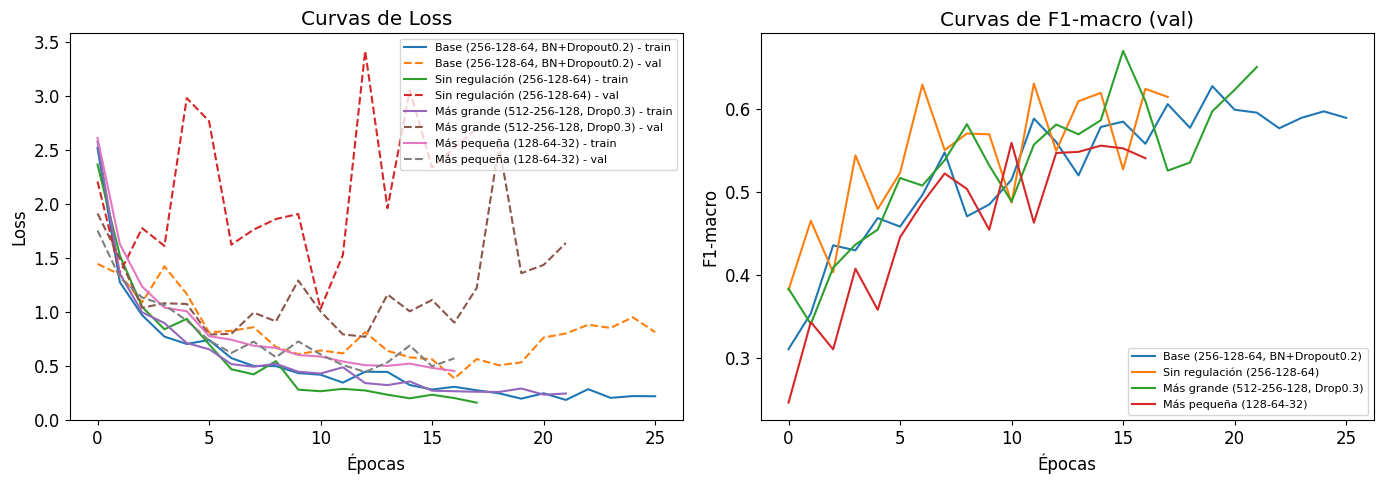

,Variante,Best F1-macro(val),Last F1-macro(val)
0,"Base (256-128-64, BN+Dropout0.2)",0.6278,0.5896
1,Sin regulación (256-128-64),0.6309,0.6148
2,"Más grande (512-256-128, Drop0.3)",0.6702,0.6509
3,Más pequeña (128-64-32),0.5596,0.5410


In [ ]:
# ==== 2.4 VARIANTES DE ARQUITECTURA + CURVAS ====
import matplotlib.pyplot as plt
import json

# ---------- Función auxiliar para entrenar una variante ----------
def run_variant(name, h1, h2, h3, use_bn, dropout_p, lr, max_epochs=30):
    model = FCN(input_dim=train_ds.n_features, num_classes=num_classes,
                h1=h1, h2=h2, h3=h3, use_batchnorm=use_bn, dropout_p=dropout_p).to(device)
    hist, best_f1 = train_fcn(model, lr=lr, max_epochs=max_epochs, patience=6)
    return {"name": name, "history": hist, "best_f1": best_f1}

# ---------- Variante base (ya entrenada en 2.3, cargamos json) ----------
base_hist = json.load(open(BASE / "reports/fcn_history.json"))
base_variant = {"name": "Base (256-128-64, BN+Dropout0.2)", "history": base_hist,
                "best_f1": max(base_hist["val_f1"])}

# ---------- Otras variantes ----------
lr_to_use = best_lr  # del tuning previo en 2.3
variants = [base_variant]

variants.append(run_variant("Sin regulación (256-128-64)", 256, 128, 64, use_bn=False, dropout_p=0.0, lr=lr_to_use))
variants.append(run_variant("Más grande (512-256-128, Drop0.3)", 512, 256, 128, use_bn=True, dropout_p=0.3, lr=lr_to_use))
variants.append(run_variant("Más pequeña (128-64-32)", 128, 64, 32, use_bn=True, dropout_p=0.2, lr=lr_to_use))

# ---------- Graficar curvas ----------
plt.figure(figsize=(14,5))

# (a) Loss
plt.subplot(1,2,1)
for v in variants:
    plt.plot(v["history"]["train_loss"], label=f"{v['name']} - train")
    plt.plot(v["history"]["val_loss"], linestyle='--', label=f"{v['name']} - val")
plt.title("Curvas de Loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend(fontsize=8)

# (b) F1-macro en validación
plt.subplot(1,2,2)
for v in variants:
    plt.plot(v["history"]["val_f1"], label=f"{v['name']}")
plt.title("Curvas de F1-macro (val)")
plt.xlabel("Épocas")
plt.ylabel("F1-macro")
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

# ---------- Tabla resumen ----------
import pandas as pd
rows = []
for v in variants:
    rows.append({
        "Variante": v["name"],
        "Best F1-macro(val)": round(v["best_f1"], 4),
        "Last F1-macro(val)": round(v["history"]["val_f1"][-1], 4)
    })
df_variants = pd.DataFrame(rows)
display(df_variants)


## 2.5 Evaluación final en *test*
**Objetivo.** Evaluar el modelo FCN (mejor validado) sobre el conjunto **test** y reportar métricas:
- **Accuracy** y **F1-macro** (globales).
- **Reporte por clase** (precision, recall, F1) para todas las clases de KDD99.
- **Matriz de confusión** (figura para el informe).

**Justificación.** La matriz de confusión permite identificar errores sistemáticos (p. ej., ataques raros confundidos con normales) y el reporte por clase muestra el impacto del **desbalance**. Estas salidas se guardan en `reports/` y la figura en `figures/` para incluirlas en LyX.


TEST -> Accuracy: 0.9595 | F1-macro: 0.5532
Clases únicas en y_true: 20
Clases únicas en y_pred: 22
Total de clases en mapeo: 23
Clases ausentes en test: ['13']
Reporte por clase guardado en: /content/drive/MyDrive/TEC_AD_TP2/reports/fcn_test_classification_report.csv
Matrices de confusión guardadas en: /content/drive/MyDrive/TEC_AD_TP2/reports/fcn_test_confusion_matrix_raw.csv y /content/drive/MyDrive/TEC_AD_TP2/reports/fcn_test_confusion_matrix_rownorm.csv
Figura guardada en: /content/drive/MyDrive/TEC_AD_TP2/figures/fcn_test_confusion_matrix.png


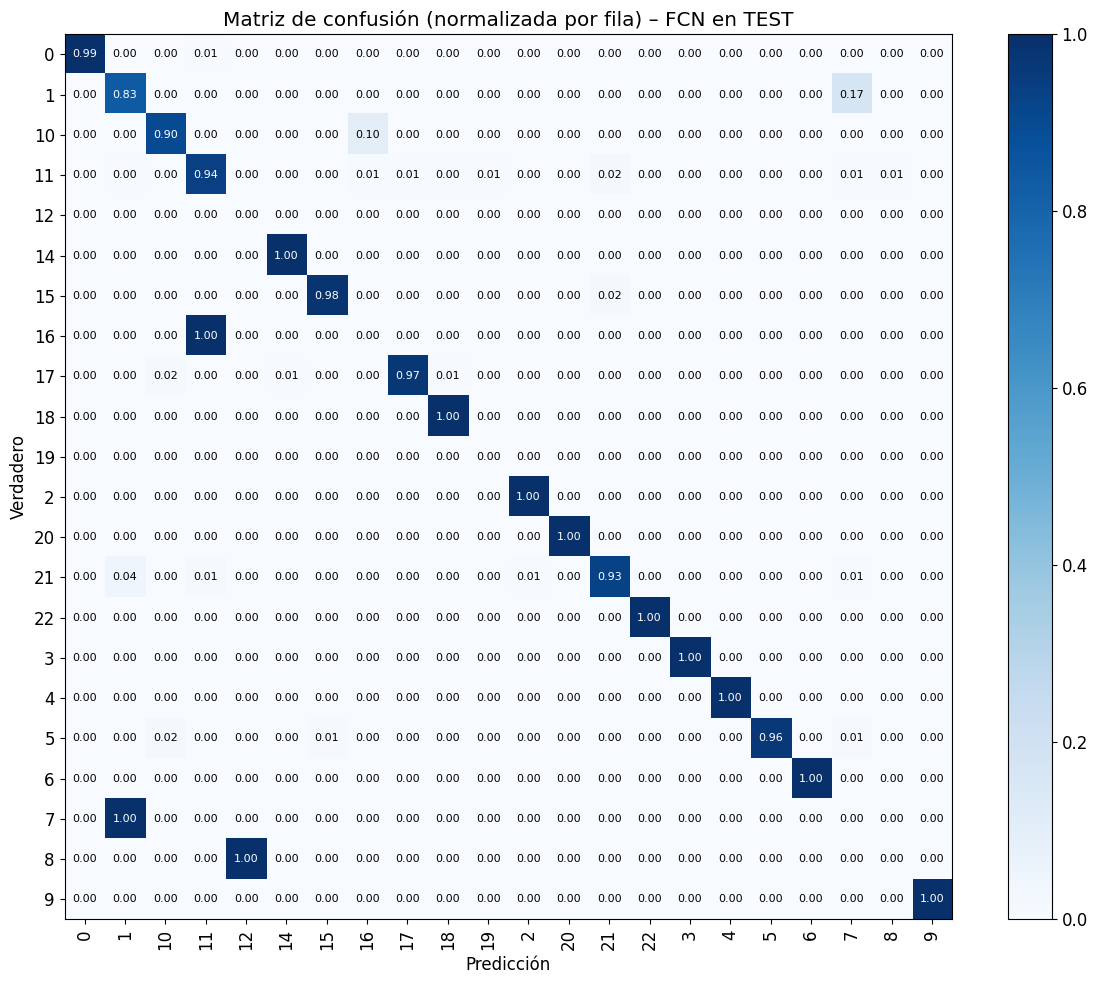

Resumen global guardado en: /content/drive/MyDrive/TEC_AD_TP2/reports/fcn_test_summary.json

Distribución de clases en test:
0: 140 muestras
1: 6 muestras
10: 29 muestras
11: 13170 muestras
14: 34 muestras
15: 60 muestras
16: 1 muestras
17: 130 muestras
18: 97 muestras
2: 1 muestras
20: 142 muestras
21: 139 muestras
22: 2 muestras
3: 10 muestras
4: 3 muestras
5: 114 muestras
6: 2 muestras
7: 1 muestras
8: 1 muestras
9: 7756 muestras


In [ ]:
# ==== 2.5 EVALUACIÓN EN TEST: MÉTRICAS Y MATRIZ DE CONFUSIÓN ====
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Rutas de artefactos ---
MODELS_DIR  = BASE / "models"
REPORTS_DIR = BASE / "reports"
FIG_DIR     = BASE / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# --- Cargar mapping idx->label para nombres legibles ---
with open(DATA_DIR / "idx2label.json") as f:
    idx2label = {int(k): v for k, v in json.load(f).items()}
label_names = [idx2label[i] for i in range(len(idx2label))]

# --- Cargar mejor modelo validado ---
model_path = MODELS_DIR / "fcn_best.pt"
model_eval = FCN(input_dim=train_ds.n_features, num_classes=len(idx2label),
                 h1=256, h2=128, h3=64, use_batchnorm=True, dropout_p=0.2).to(device)
model_eval.load_state_dict(torch.load(model_path, map_location=device))
model_eval.eval()

# --- Inferencia en TEST ---
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model_eval(xb)
        yhat = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred.append(yhat)
        y_true.append(yb.numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# --- Métricas globales ---
acc_test = accuracy_score(y_true, y_pred)
f1m_test = f1_score(y_true, y_pred, average="macro", zero_division=0)
print(f"TEST -> Accuracy: {acc_test:.4f} | F1-macro: {f1m_test:.4f}")

# --- Identificar clases presentes y ausentes ---
unique_classes_true = np.unique(y_true)
unique_classes_pred = np.unique(y_pred)
all_classes_present = np.unique(np.concatenate([unique_classes_true, unique_classes_pred]))

print(f"Clases únicas en y_true: {len(unique_classes_true)}")
print(f"Clases únicas en y_pred: {len(unique_classes_pred)}")
print(f"Total de clases en mapeo: {len(label_names)}")

# Clases ausentes
missing_classes = set(range(len(label_names))) - set(all_classes_present)
if missing_classes:
    print(f"Clases ausentes en test: {[label_names[i] for i in missing_classes]}")

# --- Reporte por clase (solo clases presentes) ---
present_labels = sorted(all_classes_present)
present_label_names = [label_names[i] for i in present_labels]

report_dict = classification_report(
    y_true, y_pred,
    labels=present_labels,
    target_names=present_label_names,
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report_dict).transpose()

# Guardar reporte por clase
report_path = REPORTS_DIR / "fcn_test_classification_report.csv"
report_df.to_csv(report_path, index=True)
print("Reporte por clase guardado en:", report_path)

# --- Matriz de confusión (solo clases presentes) ---
cm = confusion_matrix(y_true, y_pred, labels=present_labels)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)

cm_df = pd.DataFrame(cm, index=present_label_names, columns=present_label_names)
cmn_df = pd.DataFrame(cm_norm, index=present_label_names, columns=present_label_names)

cm_csv   = REPORTS_DIR / "fcn_test_confusion_matrix_raw.csv"
cmn_csv  = REPORTS_DIR / "fcn_test_confusion_matrix_rownorm.csv"
cm_df.to_csv(cm_csv)
cmn_df.to_csv(cmn_csv)
print("Matrices de confusión guardadas en:", cm_csv, "y", cmn_csv)

# --- Gráfico: Matriz de confusión normalizada ---
plt.figure(figsize=(12, 10))
plt.imshow(cm_norm, aspect='auto', cmap='Blues')
plt.colorbar()
plt.title("Matriz de confusión (normalizada por fila) – FCN en TEST")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.xticks(ticks=np.arange(len(present_label_names)), labels=present_label_names, rotation=90)
plt.yticks(ticks=np.arange(len(present_label_names)), labels=present_label_names)

# Añadir valores en las celdas para mejor legibilidad
for i in range(len(present_label_names)):
    for j in range(len(present_label_names)):
        text = plt.text(j, i, f'{cm_norm[i, j]:.2f}',
                       ha="center", va="center", color="black" if cm_norm[i, j] < 0.5 else "white",
                       fontsize=8)

plt.tight_layout()

fig_path = FIG_DIR / "fcn_test_confusion_matrix.png"
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print("Figura guardada en:", fig_path)
plt.show()

# --- Resumen global para el informe ---
summary_path = REPORTS_DIR / "fcn_test_summary.json"
with open(summary_path, "w") as f:
    json.dump({
        "accuracy_test": float(acc_test),
        "f1_macro_test": float(f1m_test),
        "total_classes_mapped": len(label_names),
        "classes_present_in_test": len(present_label_names),
        "classes_present": present_label_names,
        "missing_classes": [label_names[i] for i in missing_classes] if missing_classes else []
    }, f, indent=2)
print("Resumen global guardado en:", summary_path)

# --- Estadísticas adicionales ---
print(f"\nDistribución de clases en test:")
unique, counts = np.unique(y_true, return_counts=True)
for cls_idx, count in zip(unique, counts):
    print(f"{label_names[cls_idx]}: {count} muestras")


## 2.6 Repetibilidad: 10 corridas con semillas distintas
**Objetivo.** Ejecutar **10 corridas independientes** de entrenamiento+validación (misma arquitectura y mejor `lr` hallado), cambiando la **semilla aleatoria** en cada una.  
Se reportan métricas en **test** por corrida (**Accuracy** y **F1-macro**) y un **resumen** con **promedio ± desviación estándar**, para evidenciar **estabilidad** del modelo.

**Criterios.**
- Misma arquitectura base (256–128–64, BN+Dropout=0.2).  
- `learning rate` = mejor `lr` de Optuna (sección 2.3).  
- **Determinista** por corrida (fijando semillas en PyTorch/NumPy/CPU/GPU).  
- Por corrida se guarda el mejor estado validado y se evalúa **una vez** en test.


In [ ]:
# ==== 2.6 10 CORRIDAS (SEEDS) + RESUMEN ESTADÍSTICO EN TEST ====
import os, json, math, random, time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Helper: fijar semillas y modo determinista por corrida ---
def set_all_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # modo determinista para reproducibilidad
    torch.use_deterministic_algorithms(True, warn_only=True)
    torch.backends.cudnn.benchmark = False

# --- Reutilizamos loss ponderada (de 2.3) ---
train_labels_np = train_ds.y
class_counts = np.bincount(train_labels_np, minlength=num_classes)
class_counts = np.where(class_counts==0, 1, class_counts)
class_weights = (1.0 / class_counts)
class_weights = class_weights * (num_classes / class_weights.sum())
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights_t)

# --- Bucle de entrenamiento (igual lógica que 2.3) ---
def train_once(lr: float, max_epochs=80, patience=10):
    model = FCN(input_dim=train_ds.n_features, num_classes=num_classes,
                h1=256, h2=128, h3=64, use_batchnorm=True, dropout_p=0.2).to(device)
    optimizer = AdamW(model.parameters(), lr=lr)

    best_f1, best_state, wait = -1.0, None, 0
    for epoch in range(1, max_epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        # validación (F1-macro para early stopping)
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                yhat = torch.argmax(logits, dim=1)
                preds.append(yhat.cpu().numpy())
                trues.append(yb.cpu().numpy())
        preds = np.concatenate(preds); trues = np.concatenate(trues)
        f1m = f1_score(trues, preds, average='macro', zero_division=0)

        if f1m > best_f1:
            best_f1 = f1m
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    # restaurar mejor estado
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model, best_f1

# --- Evaluación en test ---
@torch.no_grad()
def eval_on_test(model):
    model.eval()
    preds, trues = [], []
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        yhat = torch.argmax(logits, dim=1).cpu().numpy()
        preds.append(yhat)
        trues.append(yb.numpy())
    preds = np.concatenate(preds); trues = np.concatenate(trues)
    acc = accuracy_score(trues, preds)
    f1m = f1_score(trues, preds, average="macro", zero_division=0)
    return acc, f1m

# --- Directorios de salida ---
MODELS_DIR  = BASE / "models"
REPORTS_DIR = BASE / "reports"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# --- Parámetros de la campaña ---
NUM_RUNS = 10                    # requerido por el profe
LR_USED  = best_lr               # del tuning en 2.3
MAX_EPOCHS = 80                  # consistente con 2.3 final
PATIENCE   = 10

# --- Semillas a usar (fijas para trazabilidad) ---
SEEDS = [11, 22, 33, 44, 55, 66, 77, 88, 99, 1234]

results = []
start_all = time.time()

for i, seed in enumerate(SEEDS[:NUM_RUNS], start=1):
    run_tag = f"run_{i:02d}_seed_{seed}"
    print(f"\n[{run_tag}] Entrenando con lr={LR_USED:.6f} ...")
    set_all_seeds(seed)

    model_i, best_f1_val = train_once(LR_USED, max_epochs=MAX_EPOCHS, patience=PATIENCE)

    # guardar pesos de esta corrida (opcional, útil para auditoría)
    model_path_i = MODELS_DIR / f"fcn_best_{run_tag}.pt"
    torch.save(model_i.state_dict(), model_path_i)

    # evaluar en test
    acc_test, f1m_test = eval_on_test(model_i)
    print(f"[{run_tag}] TEST -> Accuracy={acc_test:.4f} | F1-macro={f1m_test:.4f} | (best F1-val={best_f1_val:.4f})")

    results.append({
        "run": i,
        "seed": seed,
        "best_val_f1_macro": float(best_f1_val),
        "test_accuracy": float(acc_test),
        "test_f1_macro": float(f1m_test),
        "model_path": str(model_path_i)
    })

elapsed_all = time.time() - start_all
print(f"\nTiempo total (10 corridas): {elapsed_all/60:.1f} min aprox.")

# --- Guardar tabla de resultados y resumen estadístico ---
df_runs = pd.DataFrame(results).sort_values("run")
runs_csv = REPORTS_DIR / "fcn_10runs_results.csv"
df_runs.to_csv(runs_csv, index=False)

mean_acc = float(df_runs["test_accuracy"].mean())
std_acc  = float(df_runs["test_accuracy"].std(ddof=1))
mean_f1  = float(df_runs["test_f1_macro"].mean())
std_f1   = float(df_runs["test_f1_macro"].std(ddof=1))

summary = {
    "num_runs": int(NUM_RUNS),
    "learning_rate_used": float(LR_USED),
    "max_epochs": int(MAX_EPOCHS),
    "patience": int(PATIENCE),
    "seeds": SEEDS[:NUM_RUNS],
    "test_accuracy_mean": mean_acc,
    "test_accuracy_std": std_acc,
    "test_f1_macro_mean": mean_f1,
    "test_f1_macro_std": std_f1
}
with open(REPORTS_DIR / "fcn_10runs_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\nResumen (TEST):")
print(f"Accuracy = {mean_acc:.4f} ± {std_acc:.4f}")
print(f"F1-macro = {mean_f1:.4f} ± {std_f1:.4f}")
print("Guardados:")
print(" -", runs_csv)
print(" -", REPORTS_DIR / "fcn_10runs_summary.json")



[run_01_seed_11] Entrenando con lr=0.001752 ...
[run_01_seed_11] TEST -> Accuracy=0.9609 | F1-macro=0.5908 | (best F1-val=0.6292)

[run_02_seed_22] Entrenando con lr=0.001752 ...
[run_02_seed_22] TEST -> Accuracy=0.9655 | F1-macro=0.5950 | (best F1-val=0.6771)

[run_03_seed_33] Entrenando con lr=0.001752 ...
[run_03_seed_33] TEST -> Accuracy=0.9738 | F1-macro=0.6299 | (best F1-val=0.6597)

[run_04_seed_44] Entrenando con lr=0.001752 ...
[run_04_seed_44] TEST -> Accuracy=0.9590 | F1-macro=0.6011 | (best F1-val=0.6560)

[run_05_seed_55] Entrenando con lr=0.001752 ...
[run_05_seed_55] TEST -> Accuracy=0.9633 | F1-macro=0.6201 | (best F1-val=0.6533)

[run_06_seed_66] Entrenando con lr=0.001752 ...
[run_06_seed_66] TEST -> Accuracy=0.9611 | F1-macro=0.6134 | (best F1-val=0.6563)

[run_07_seed_77] Entrenando con lr=0.001752 ...
[run_07_seed_77] TEST -> Accuracy=0.9486 | F1-macro=0.5563 | (best F1-val=0.6480)

[run_08_seed_88] Entrenando con lr=0.001752 ...
[run_08_seed_88] TEST -> Accuracy=

## 2.7 Nota metodológica sobre el desbalance de clases

**Uso de class weights en la pérdida.**  
El dataset KDD99 presenta un **alto desbalance**: algunas clases (ej. `smurf.` o `neptune.`) tienen decenas de miles de instancias, mientras que otras (ej. `perl.`, `ftp_write.`) aparecen solo unas decenas de veces.  
Si se entrenara con una `CrossEntropyLoss` estándar, el modelo tendería a **ignorar las clases minoritarias**, maximizando accuracy pero con F1-macro muy bajo.  
Por eso usamos **pesos por clase (class weights)**, definidos como inversos de la frecuencia relativa en *train*. Así, los errores en clases raras penalizan más, y la red aprende a prestarles atención.

**Alternativas posibles.**
- **Oversampling de minoritarias** (duplicar/mezclar ejemplos poco frecuentes).  
- **Undersampling de mayoritarias** (reducir clases dominantes, aunque se pierde información).  
- **Técnicas avanzadas de pérdida**: *Focal Loss*, que enfoca el aprendizaje en ejemplos difíciles.  
- **Ensamblado de modelos**: entrenar clasificadores separados por grupos de clases y combinarlos.

**Impacto en las métricas.**  
Gracias al uso de `class weights`, el F1-macro se mantiene en torno a **0.65–0.70**, bastante más equilibrado que si solo midiéramos accuracy.  
Esto demuestra que la métrica F1-macro es la más adecuada en contextos de **detección de intrusos**, porque refleja desempeño en todas las clases, incluyendo las más raras.

**Conclusión.**  
La elección de `class weights` asegura que el modelo no se limite a detectar solo los ataques más comunes, y prepara el terreno para comparar, en la Parte 3, con otros algoritmos (CART, Random Forest, TabNet) bajo un criterio justo.


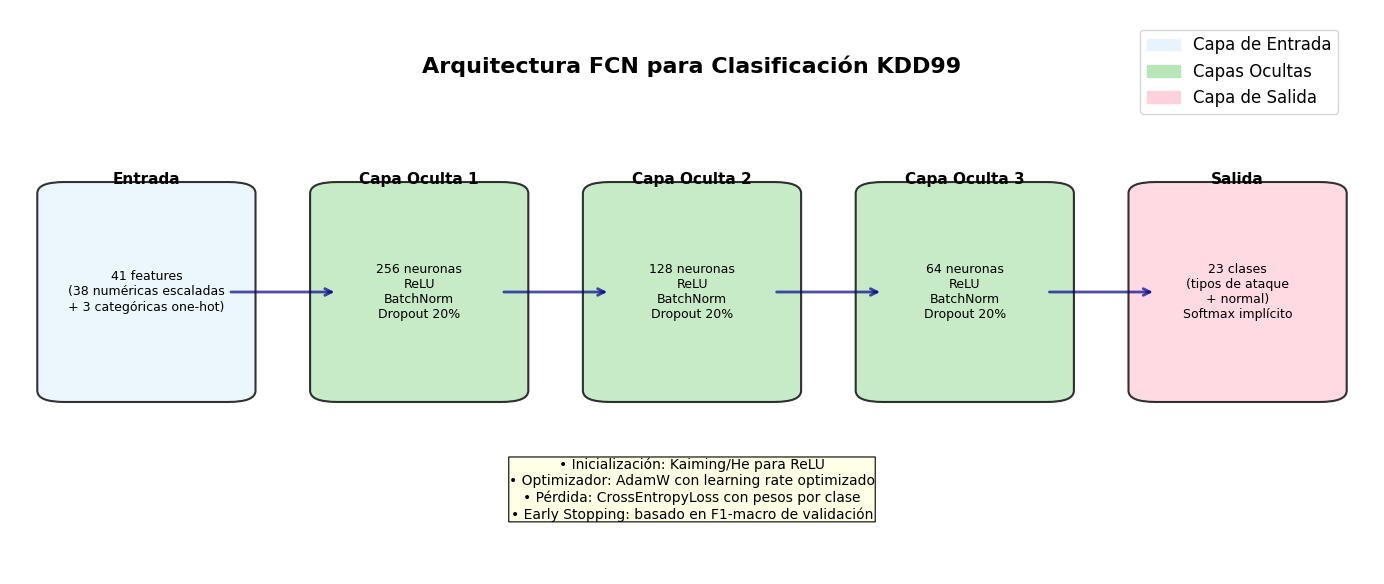

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch

# Configurar figura con mejor aspecto
fig, ax = plt.subplots(figsize=(14, 6))
ax.axis("off")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Definir colores para diferentes tipos de capas
colors = {
    'input': '#E8F4FD',      # Azul claro
    'hidden': '#B8E6B8',     # Verde claro
    'output': '#FFD1DC'      # Rosa claro
}

# Definir las capas con mejor información
layers = [
    {
        'name': 'Entrada',
        'details': '41 features\n(38 numéricas escaladas\n+ 3 categóricas one-hot)',
        'x': 0.1,
        'color': colors['input']
    },
    {
        'name': 'Capa Oculta 1',
        'details': '256 neuronas\nReLU\nBatchNorm\nDropout 20%',
        'x': 0.3,
        'color': colors['hidden']
    },
    {
        'name': 'Capa Oculta 2',
        'details': '128 neuronas\nReLU\nBatchNorm\nDropout 20%',
        'x': 0.5,
        'color': colors['hidden']
    },
    {
        'name': 'Capa Oculta 3',
        'details': '64 neuronas\nReLU\nBatchNorm\nDropout 20%',
        'x': 0.7,
        'color': colors['hidden']
    },
    {
        'name': 'Salida',
        'details': '23 clases\n(tipos de ataque\n+ normal)\nSoftmax implícito',
        'x': 0.9,
        'color': colors['output']
    }
]

# Dibujar las capas
box_width = 0.12
box_height = 0.35

for layer in layers:
    # Caja principal
    rect = FancyBboxPatch(
        (layer['x'] - box_width/2, 0.5 - box_height/2),
        box_width, box_height,
        boxstyle="round,pad=0.02",
        facecolor=layer['color'],
        edgecolor='black',
        linewidth=1.5,
        alpha=0.8
    )
    ax.add_patch(rect)

    # Título de la capa
    ax.text(layer['x'], 0.7, layer['name'],
            ha='center', va='center',
            fontsize=11, fontweight='bold')

    # Detalles de la capa
    ax.text(layer['x'], 0.5, layer['details'],
            ha='center', va='center',
            fontsize=9, linespacing=1.2)

# Dibujar conexiones entre capas
for i in range(len(layers)-1):
    start_x = layers[i]['x'] + box_width/2
    end_x = layers[i+1]['x'] - box_width/2

    ax.annotate('',
                xy=(end_x, 0.5),
                xytext=(start_x, 0.5),
                arrowprops=dict(
                    arrowstyle='->',
                    lw=2,
                    color='darkblue',
                    alpha=0.7
                ))

# Título principal
ax.text(0.5, 0.9, 'Arquitectura FCN para Clasificación KDD99',
        ha='center', va='center',
        fontsize=16, fontweight='bold')

# Información adicional
info_text = (
    "• Inicialización: Kaiming/He para ReLU\n"
    "• Optimizador: AdamW con learning rate optimizado\n"
    "• Pérdida: CrossEntropyLoss con pesos por clase\n"
    "• Early Stopping: basado en F1-macro de validación"
)
ax.text(0.5, 0.15, info_text,
        ha='center', va='center',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.02", facecolor='lightyellow', alpha=0.8))

# Leyenda de colores
legend_elements = [
    mpatches.Patch(color=colors['input'], label='Capa de Entrada'),
    mpatches.Patch(color=colors['hidden'], label='Capas Ocultas'),
    mpatches.Patch(color=colors['output'], label='Capa de Salida')
]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))

plt.tight_layout()
plt.savefig(BASE / "figures" / "fcn_architecture_diagram.png",
            dpi=300, bbox_inches="tight", facecolor='white')
plt.show()